## Canny Edge Detector

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math
import cv2
import sys

In [2]:
def show(file):
    plt.imshow(file,cmap ='gray')  
    plt.show()

In [3]:
def readImage(filename):

    img = plt.imread(filename, 0)
    if img.ndim == 3:
        img = img[:,:,0] 
    return img

### original image

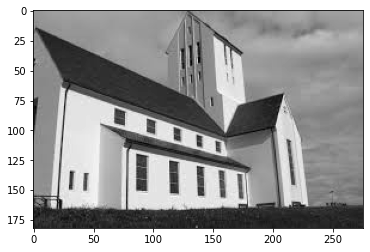

In [4]:
img = readImage("example_img/img.jpg")
show(img)

### Implement gaussian convolution as a separable sequence of horizontal and vertical convolutions.

In [5]:
def Hx(size, s):
    sigma = s
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = (-x/sigma**2)*np.exp(-((x**2 + y**2) / (2.0*sigma**2)))
    return g

def Hy(size, s):
    sigma = s
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = (-y/sigma**2)*np.exp(-((x**2 + y**2) / (2.0*sigma**2)))
    return g

def magnitude(matrix1,matrix2):
    new_matrix = [[0 for i in range(len(matrix1[0]))] for j in range(len(matrix1))]
    for i in range(len(matrix1)):
        for j in range(len(matrix1[0])):          
            new_matrix[i][j] = math.sqrt(matrix1[i][j]**2 + matrix2[i][j]**2)
    return new_matrix

In [6]:
sigma = 11

In [7]:
Ix = cv2.filter2D(img,-1,Hx(3,sigma))
Iy = cv2.filter2D(img,-1,Hy(3,sigma))
img = np.asarray(magnitude(Ix,Iy))

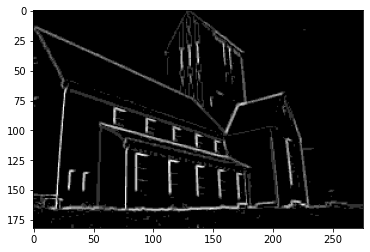

In [8]:
show(img)

### Thining edges

In [9]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
  
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

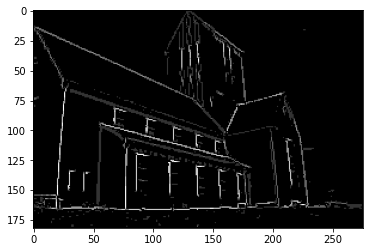

In [10]:
theta = np.arctan2(Ix, Iy)
img = non_max_suppression(img, theta)
show(img)

###  extract solid edges

In [11]:
def threshold(img,low,high):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        highThreshold = img.max() * high;
        lowThreshold = highThreshold * low;

        for i in range(len(img)):
            for j in range(len(img[0])):
                if(img[i][j] > highThreshold):
                    Z[i][j] = 255
                elif (img[i][j] < lowThreshold):
                    Z[i][j] = 0
                else:
                    Z[i][j] = img[i][j]

        return Z

In [12]:
lowThreshold = 0.05
highThreshold = 0.15

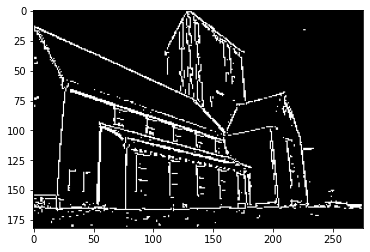

In [13]:
img = threshold(img,lowThreshold,highThreshold)
show(img)

### connect edges inbetween

In [14]:
def hysteresis(img):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] != 255 and img[i,j] != 0):
                try:
                    if ((img[i+1, j-1] == 255) or (img[i+1, j] == 255) or (img[i+1, j+1] == 255)
                        or (img[i, j-1] == 255) or (img[i, j+1] == 255)
                        or (img[i-1, j-1] == 255) or (img[i-1, j] == 255) or (img[i-1, j+1] == 255)):
                        img[i, j] = 255
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

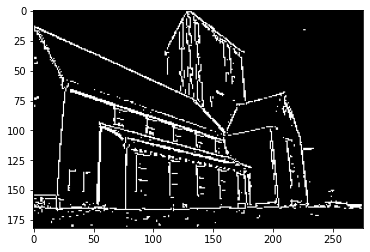

In [15]:
img = hysteresis(img)
show(img)

## Harris Corner Detector

In [16]:
def kernel():
    size = 5
    sigma = 5
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = (-x/sigma**2)*np.exp(-((x**2 + y**2) / (2.0*sigma**2)))
    return g

In [17]:
def findCorners(img, window_size, k, threshold):

    Iy, Ix = np.gradient(img)
    Ixx = Ix**2
    Ixy = Iy*Ix
    Iyy = Iy**2
    theta = np.arctan2(Ix, Iy)
    height = img.shape[0]
    width = img.shape[1]
    offset = window_size//2


    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)
            if r < threshold:
                img[y][x] = 0
           
    return img, theta

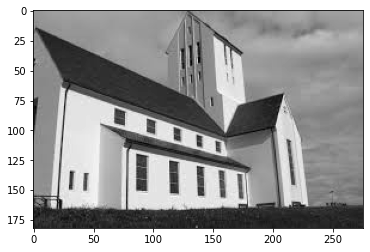

In [18]:
window_size = 7
k = 0.1
threshold = 10000
image = readImage("example_img/img.jpg")
show(image)

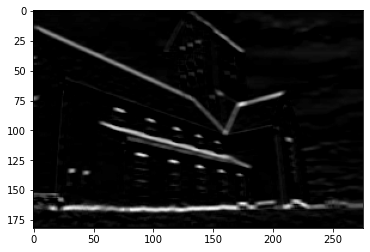

In [19]:
image = cv2.filter2D(image,-1,kernel())
show(image)

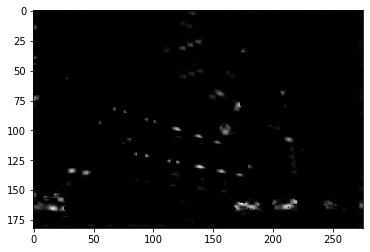

In [20]:
image,theta = findCorners(image, window_size, k, threshold)
show(image)

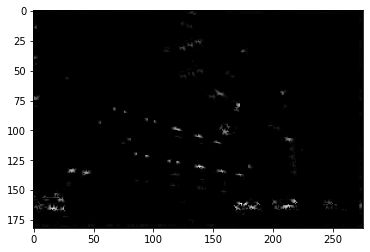

In [21]:
image = non_max_suppression(image,theta)
show(image)